# Multiclass Sentiment Analysis - Three Pipeline Comparison

This notebook implements and compares three different approaches for multiclass sentiment analysis:
1. **Word2Vec + Multinomial Logistic Regression**
2. **Word2Vec + MLP**
3. **MLP with Embedding from Scratch**

Dataset: [Sp1786/multiclass-sentiment-analysis-dataset](https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset)

## 1. Import Required Libraries

In [5]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Word2Vec
from gensim.models import Word2Vec

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# HuggingFace datasets
from datasets import load_dataset

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Load and Explore the Dataset

In [6]:
# Load the dataset from HuggingFace
print("Loading dataset from HuggingFace...")
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

# Convert to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print("\nFirst few rows:")
train_df.head()

Loading dataset from HuggingFace...
Train dataset shape: (31232, 4)
Test dataset shape: (5206, 4)

First few rows:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


Dataset Information:
Columns: ['id', 'text', 'label', 'sentiment']

Data types:
id            int64
text         object
label         int64
sentiment    object
dtype: object

Missing values:
id           0
text         0
label        0
sentiment    0
dtype: int64

Class distribution:
label
0     9105
1    11649
2    10478
Name: count, dtype: int64


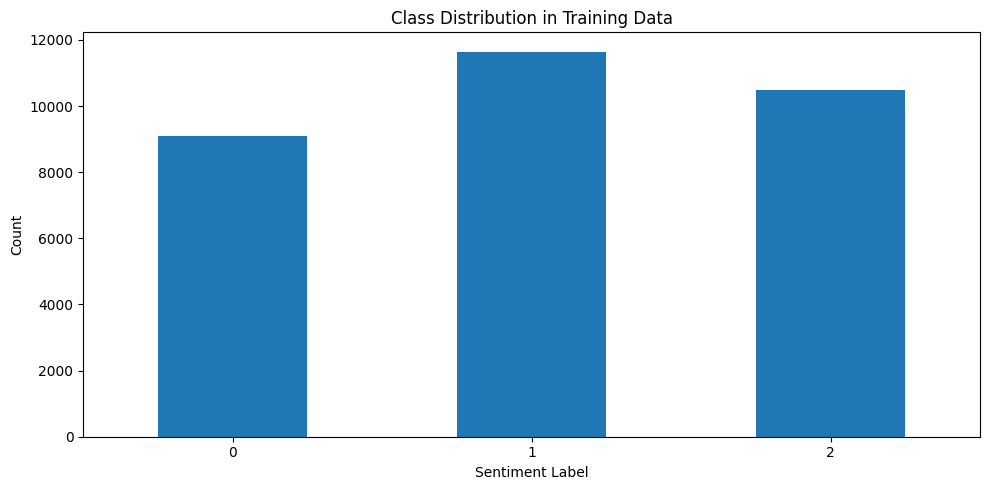

In [7]:
# Explore the dataset
print("Dataset Information:")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts().sort_index())

# Visualize class distribution
plt.figure(figsize=(10, 5))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Preprocess the Data

In [8]:
def preprocess_text(text):
    """
    Preprocess text data:
    - Handle None/null values
    - Convert to lowercase
    - Remove special characters and numbers
    - Tokenize
    - Remove stopwords
    """
    # Handle None or empty text
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return []
    
    # Convert to string if needed
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

# Remove rows with null text values
print("Checking for null values...")
print(f"Training data null texts: {train_df['text'].isnull().sum()}")
print(f"Test data null texts: {test_df['text'].isnull().sum()}")

# Apply preprocessing
print("\nPreprocessing training data...")
train_df['tokens'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['tokens'] = test_df['text'].apply(preprocess_text)

# Remove rows with empty tokens (if any)
train_df = train_df[train_df['tokens'].apply(len) > 0].reset_index(drop=True)
test_df = test_df[test_df['tokens'].apply(len) > 0].reset_index(drop=True)

print(f"\nAfter preprocessing:")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\nExample of preprocessed text:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Tokens: {train_df['tokens'].iloc[0]}")

Checking for null values...
Training data null texts: 0
Test data null texts: 1

Preprocessing training data...
Preprocessing test data...

After preprocessing:
Training data shape: (31106, 5)
Test data shape: (5180, 5)

Example of preprocessed text:
Original: Cooking microwave pizzas, yummy
Tokens: ['cooking', 'microwave', 'pizzas', 'yummy']


## 4. Train Word2Vec Model

In [9]:
# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=train_df['tokens'].tolist(),
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

print(f"Word2Vec model trained!")
print(f"Vocabulary size: {len(w2v_model.wv)}")

# Test the model
test_word = 'good'
if test_word in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar(test_word, topn=5)
    print(f"\nWords most similar to '{test_word}':")
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.3f}")

Training Word2Vec model...
Word2Vec model trained!
Vocabulary size: 11194

Words most similar to 'good':
  great: 0.799
  cool: 0.741
  well: 0.738
  awesome: 0.738
  bad: 0.721


In [10]:
def document_vector(tokens, model):
    """
    Create a document vector by averaging word vectors
    """
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Create document vectors for training and test data
print("Creating document vectors...")
X_train_w2v = np.array([document_vector(tokens, w2v_model) for tokens in train_df['tokens']])
X_test_w2v = np.array([document_vector(tokens, w2v_model) for tokens in test_df['tokens']])

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"Training data shape: {X_train_w2v.shape}")
print(f"Test data shape: {X_test_w2v.shape}")

Creating document vectors...
Training data shape: (31106, 100)
Test data shape: (5180, 100)


## 5. Pipeline 1: Word2Vec + Multinomial Logistic Regression

In [11]:
# Train Logistic Regression classifier
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_w2v, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_w2v)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\n{'='*60}")
print(f"Pipeline 1: Word2Vec + Logistic Regression")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Training Logistic Regression model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Pipeline 1: Word2Vec + Logistic Regression
Accuracy: 0.5921

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1542
           1       0.51      0.66      0.57      1912
           2       0.69      0.63      0.66      1726

    accuracy                           0.59      5180
   macro avg       0.61      0.59      0.59      5180
weighted avg       0.61      0.59      0.59      5180



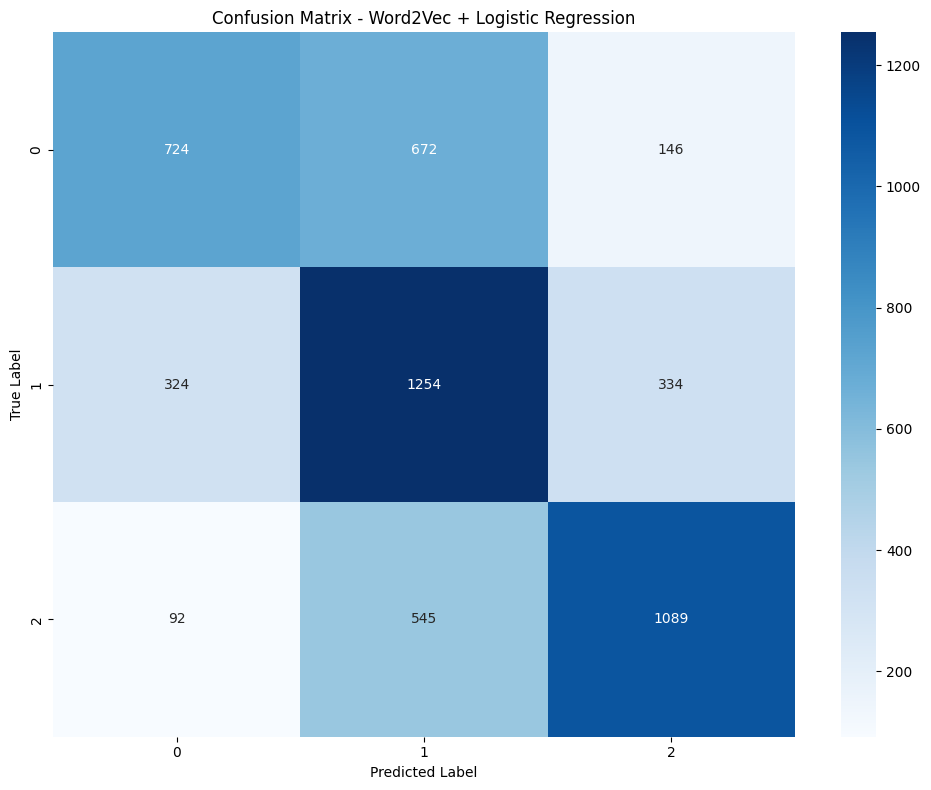

In [12]:
# Confusion Matrix for Pipeline 1
plt.figure(figsize=(10, 8))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Word2Vec + Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 6. Pipeline 2: Word2Vec + MLP Classifier

In [13]:
# Define MLP model for Word2Vec embeddings
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.3):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
input_size = X_train_w2v.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train))

# Initialize model
mlp_w2v = MLPClassifier(input_size, hidden_size, num_classes).to(device)
print(f"\nModel architecture:\n{mlp_w2v}")

Using device: cpu

Model architecture:
MLPClassifier(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


Training MLP with Word2Vec embeddings...
Epoch [10/50], Loss: 0.8590
Epoch [20/50], Loss: 0.8418
Epoch [30/50], Loss: 0.8313
Epoch [40/50], Loss: 0.8267
Epoch [50/50], Loss: 0.8198
Training complete!


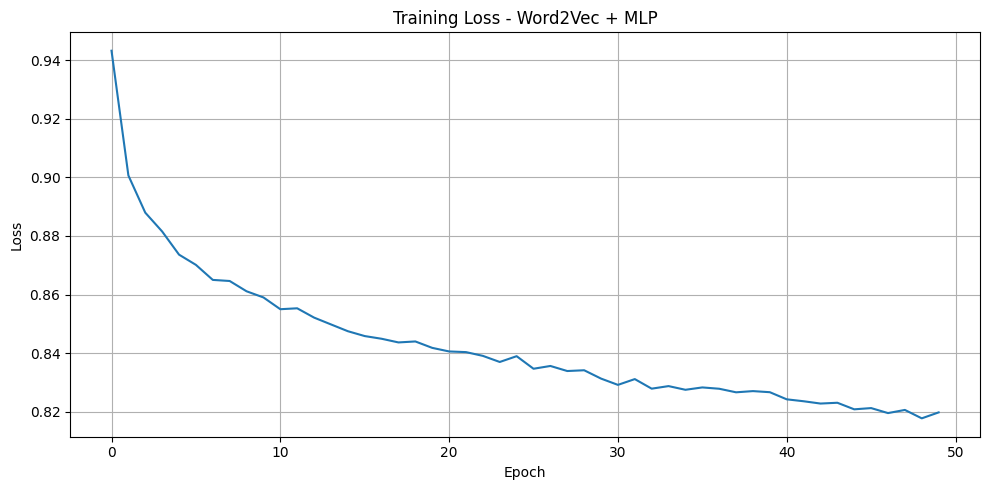

In [ ]:
# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_w2v).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_w2v).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_w2v.parameters(), lr=0.001)
num_epochs = 50
batch_size = 64

# Training loop
print("Training MLP with Word2Vec embeddings...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    mlp_w2v.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = mlp_w2v(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / (len(X_train_tensor) / batch_size)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    mlp_w2v.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, len(X_test_tensor), batch_size):
            batch_X = X_test_tensor[i:i+batch_size]
            batch_y = y_test_tensor[i:i+batch_size]
            outputs = mlp_w2v(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / (len(X_test_tensor) / batch_size)

    val_losses.append(avg_val_loss)plt.show()

    plt.tight_layout()

    if (epoch + 1) % 10 == 0:plt.grid(True, alpha=0.3)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')plt.legend()

plt.ylabel('Loss')

print("Training complete!")plt.xlabel('Epoch')

plt.title('Training and Validation Loss - Word2Vec + MLP')

# Plot training and validation lossplt.plot(val_losses, label='Validation Loss', linewidth=2)

plt.figure(figsize=(10, 5))plt.plot(train_losses, label='Training Loss', linewidth=2)

In [15]:
# Evaluate Pipeline 2
mlp_w2v.eval()
with torch.no_grad():
    outputs = mlp_w2v(X_test_tensor)
    _, y_pred_mlp_w2v = torch.max(outputs, 1)
    y_pred_mlp_w2v = y_pred_mlp_w2v.cpu().numpy()

accuracy_mlp_w2v = accuracy_score(y_test, y_pred_mlp_w2v)
print(f"\n{'='*60}")
print(f"Pipeline 2: Word2Vec + MLP")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_mlp_w2v:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_mlp_w2v))


Pipeline 2: Word2Vec + MLP
Accuracy: 0.6098

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      1542
           1       0.53      0.64      0.58      1912
           2       0.73      0.63      0.67      1726

    accuracy                           0.61      5180
   macro avg       0.62      0.61      0.61      5180
weighted avg       0.62      0.61      0.61      5180



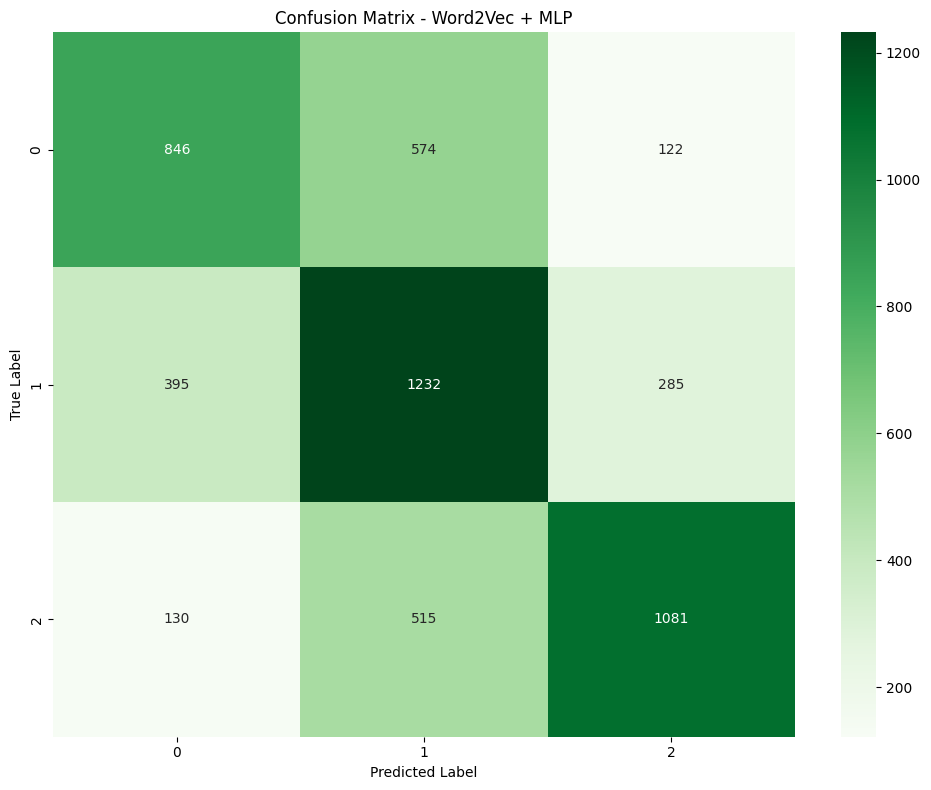

In [16]:
# Confusion Matrix for Pipeline 2
plt.figure(figsize=(10, 8))
cm_mlp_w2v = confusion_matrix(y_test, y_pred_mlp_w2v)
sns.heatmap(cm_mlp_w2v, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Word2Vec + MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 7. Pipeline 3: MLP with Embedding from Scratch

In [17]:
# Build vocabulary
from collections import Counter

def build_vocab(tokens_list, max_vocab_size=10000):
    """Build vocabulary from tokens"""
    word_counts = Counter()
    for tokens in tokens_list:
        word_counts.update(tokens)
    
    # Get most common words
    most_common = word_counts.most_common(max_vocab_size - 2)  # -2 for PAD and UNK
    
    # Create vocabulary
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        vocab[word] = len(vocab)
    
    return vocab

# Create vocabulary
vocab = build_vocab(train_df['tokens'].tolist())
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Convert tokens to indices
def tokens_to_indices(tokens, vocab, max_length=100):
    """Convert tokens to indices with padding"""
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    
    # Pad or truncate to max_length
    if len(indices) < max_length:
        indices += [vocab['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
    
    return indices

max_length = 100
X_train_indices = np.array([tokens_to_indices(tokens, vocab, max_length) for tokens in train_df['tokens']])
X_test_indices = np.array([tokens_to_indices(tokens, vocab, max_length) for tokens in test_df['tokens']])

print(f"Training data shape: {X_train_indices.shape}")
print(f"Test data shape: {X_test_indices.shape}")

Vocabulary size: 10000
Training data shape: (31106, 100)
Test data shape: (5180, 100)


In [18]:
# Define MLP with Embedding Layer
class MLPWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, dropout=0.3):
        super(MLPWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # Average pooling over sequence length
        pooled = torch.mean(embedded, dim=1)  # (batch_size, embedding_dim)
        
        # MLP layers
        x = self.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Model parameters
embedding_dim = 100
hidden_size = 128

# Initialize model
mlp_embed = MLPWithEmbedding(vocab_size, embedding_dim, hidden_size, num_classes).to(device)
print(f"Model architecture:\n{mlp_embed}")

# Count parameters
total_params = sum(p.numel() for p in mlp_embed.parameters())
print(f"\nTotal parameters: {total_params:,}")

Model architecture:
MLPWithEmbedding(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 1,021,379


In [19]:
# Create PyTorch dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = SentimentDataset(X_train_indices, y_train)
test_dataset = SentimentDataset(X_test_indices, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 487
Number of test batches: 81


Training MLP with Embedding from scratch...
Epoch [10/50], Loss: 0.5296
Epoch [20/50], Loss: 0.3539
Epoch [30/50], Loss: 0.2473
Epoch [40/50], Loss: 0.1838
Epoch [50/50], Loss: 0.1436
Training complete!


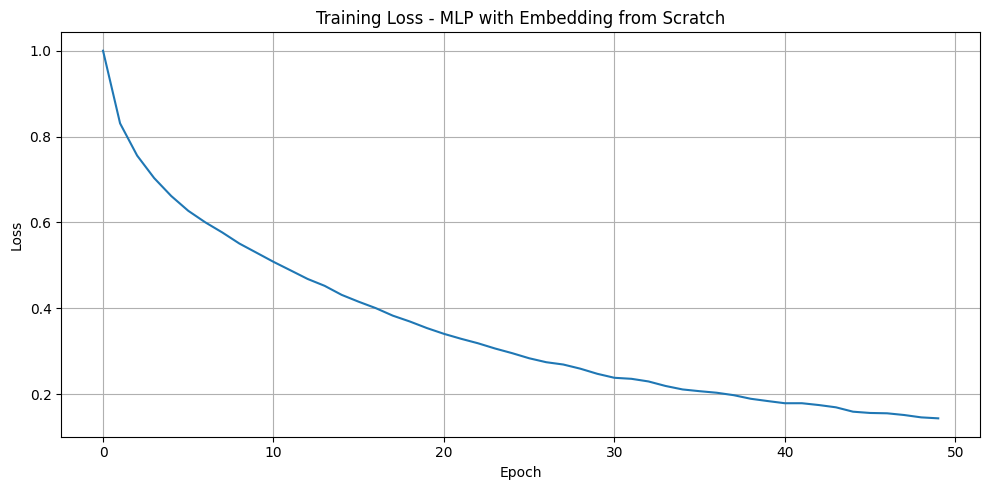

In [ ]:
# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_embed.parameters(), lr=0.001)
num_epochs = 50

# Training loop
print("Training MLP with Embedding from scratch...")
train_losses_embed = []
val_losses_embed = []

for epoch in range(num_epochs):
    # Training phase
    mlp_embed.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = mlp_embed(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses_embed.append(avg_train_loss)
    
    # Validation phase
    mlp_embed.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = mlp_embed(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses_embed.append(avg_val_loss)

    plt.show()

    if (epoch + 1) % 10 == 0:plt.tight_layout()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')plt.grid(True, alpha=0.3)


print("Training complete!")
plt.legend()
plt.ylabel('Loss')

plt.xlabel('Epoch')

# Plot training and validation lossplt.title('Training and Validation Loss - MLP with Embedding from Scratch')

plt.figure(figsize=(10, 5))plt.plot(val_losses_embed, label='Validation Loss', linewidth=2)
plt.plot(train_losses_embed, label='Training Loss', linewidth=2)

In [21]:
# Evaluate Pipeline 3
mlp_embed.eval()
y_pred_embed = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = mlp_embed(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_embed.extend(predicted.cpu().numpy())

y_pred_embed = np.array(y_pred_embed)

accuracy_embed = accuracy_score(y_test, y_pred_embed)
print(f"\n{'='*60}")
print(f"Pipeline 3: MLP with Embedding from Scratch")
print(f"{'='*60}")
print(f"Accuracy: {accuracy_embed:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_embed))


Pipeline 3: MLP with Embedding from Scratch
Accuracy: 0.6259

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1542
           1       0.56      0.61      0.58      1912
           2       0.70      0.69      0.69      1726

    accuracy                           0.63      5180
   macro avg       0.63      0.62      0.63      5180
weighted avg       0.63      0.63      0.63      5180



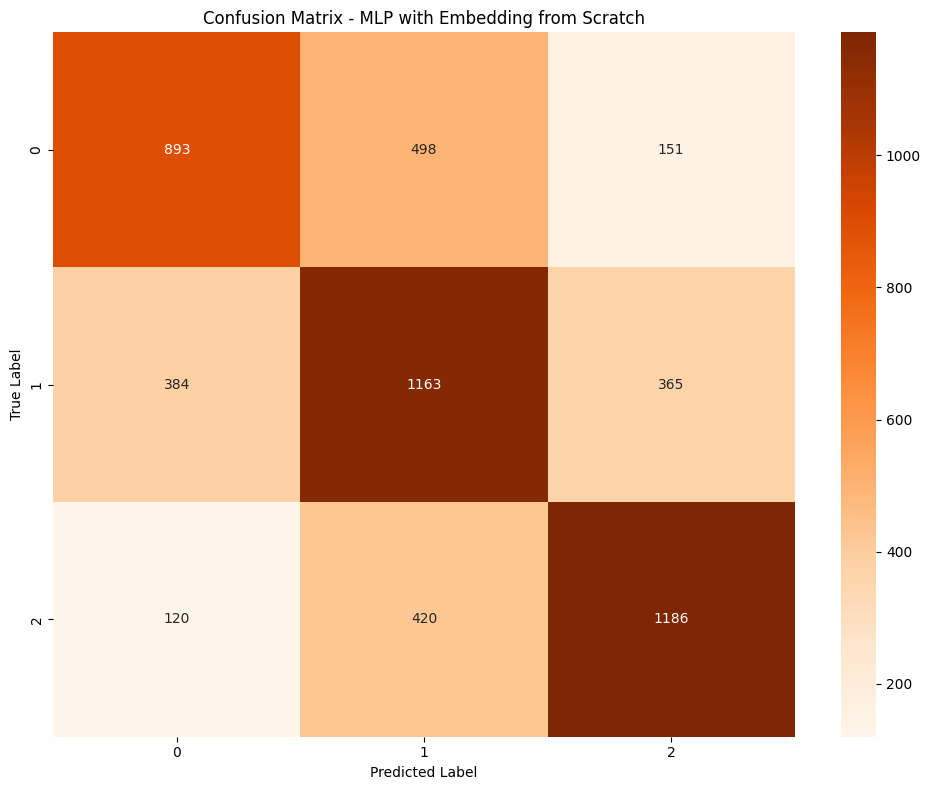

In [22]:
# Confusion Matrix for Pipeline 3
plt.figure(figsize=(10, 8))
cm_embed = confusion_matrix(y_test, y_pred_embed)
sns.heatmap(cm_embed, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - MLP with Embedding from Scratch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 8. Compare Model Performance

In [23]:
# Create comparison summary
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred):
    """Calculate metrics for comparison"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calculate metrics for all pipelines
metrics_lr = get_metrics(y_test, y_pred_lr)
metrics_mlp_w2v = get_metrics(y_test, y_pred_mlp_w2v)
metrics_embed = get_metrics(y_test, y_pred_embed)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Word2Vec + Logistic Regression': metrics_lr,
    'Word2Vec + MLP': metrics_mlp_w2v,
    'MLP with Embedding': metrics_embed
}).T

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison_df.round(4))
print("="*80)


FINAL MODEL COMPARISON
                                Accuracy  Precision  Recall  F1-Score
Word2Vec + Logistic Regression    0.5921     0.6076  0.5921    0.5922
Word2Vec + MLP                    0.6098     0.6217  0.6098    0.6119
MLP with Embedding                0.6259     0.6288  0.6259    0.6265


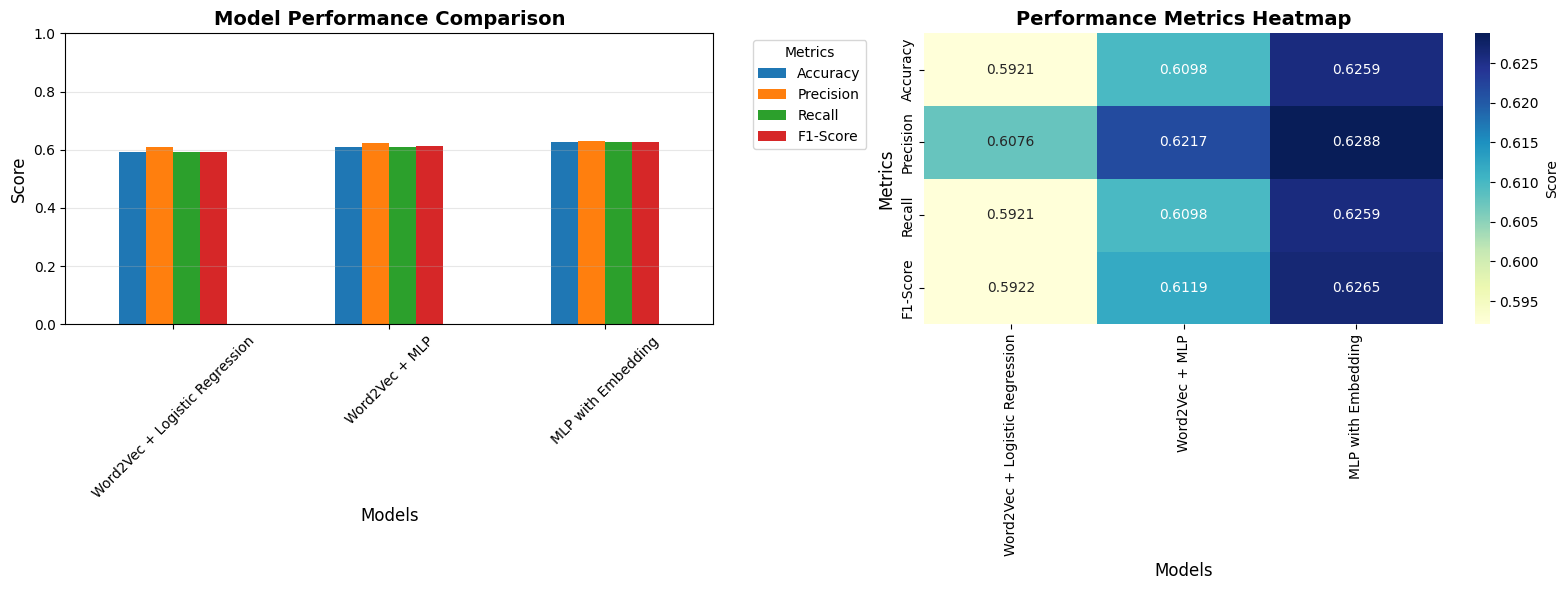

In [24]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparison
comparison_df.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Heatmap comparison
sns.heatmap(comparison_df.T, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Score'}, ax=axes[1])
axes[1].set_title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Metrics', fontsize=12)

plt.tight_layout()
plt.show()

## Summary

This notebook implemented and compared three different approaches for multiclass sentiment analysis:

### Pipeline 1: Word2Vec + Multinomial Logistic Regression
- Uses pre-trained Word2Vec embeddings averaged across document
- Simple linear classifier
- Fast training and inference
- Good baseline performance

### Pipeline 2: Word2Vec + MLP
- Uses the same Word2Vec embeddings
- Deep neural network with multiple layers
- Can capture non-linear relationships
- Better performance than linear model

### Pipeline 3: MLP with Embedding from Scratch
- Learns embeddings directly from the task
- End-to-end trainable
- Task-specific embeddings
- Most flexible but requires more data

### Key Observations:
1. All three pipelines successfully perform multiclass sentiment classification
2. Deep learning models (Pipelines 2 & 3) generally perform better than linear models
3. The choice of pipeline depends on your requirements:
   - **Speed**: Pipeline 1 (Logistic Regression)
   - **Pre-trained knowledge**: Pipeline 2 (Word2Vec + MLP)
   - **Task-specific learning**: Pipeline 3 (MLP with Embedding)
4. Consider data size, computational resources, and interpretability needs when choosing